In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.lines import Line2D
import scipy.stats as sps

import pickle

import arviz as az
import pyjags

from IPython.display import HTML, Latex, Markdown, clear_output

# Abstract

A simple method is presented to predict new cases and Percent Positive, estimated on effective reproduction number $R_t$ of COVID-19 in italian regions with a Markov chain Monte Carlo and Poisson likelihood parametrized on daily new cases.

# Method

New cases $y_r$ in Italy (source [Dipartimento Protezione Civile](https://github.com/pcm-dpc/COVID-19)), will be smoothed with rolling mean (gaussian, window 7, std 2). Smoothed new cases will be adjusted to be $>0$ to avoid negative values (due to data error corrections).

For each day $t=[0,T]$ (where $T$ is the last observed day), smoothed new cases $y_{t}$ will be supposed distributed as **Poisson** with $\lambda_{t}$ parameter

$$
y_{t} \sim \mathcal{P}(\lambda_{t})
$$

where $\lambda_{t}$ is defined by the serial interval inverse $\gamma$, previous day smoothed new cases $k_{t-1}$ and effective reproduction number in time $R_{t}$ (ref: [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185))

$$
\lambda_{t} = k_{t-1} e^{\gamma (R_{t} - 1)}
$$

In [2]:
SI_mu = 7.5
SI_sd = 3.4

In [3]:
display(Markdown(fr"""
The serial interval **SI** is supposed to be distributed as **Gamma**, 
with mean $\mu={SI_mu}$ and standard deviation $\sigma={SI_sd}$
(ref: [Li, Ghuan et Al. 2020a](https://www.sciencedirect.com/science/article/pii/S2468042720300063#bib6))

$$
\mathbf{{SI}} \sim \Gamma(\mu_{{={SI_mu}}}, \sigma_{{={SI_sd}}})
$$

so that $\gamma$ is distributed as **Inverse Gamma**

$$
\gamma \sim \Gamma^{{-1}}(\mu_{{={SI_mu}}}, \sigma_{{={SI_sd}}})
$$
"""))


The serial interval **SI** is supposed to be distributed as **Gamma**, 
with mean $\mu=7.5$ and standard deviation $\sigma=3.4$
(ref: [Li, Ghuan et Al. 2020a](https://www.sciencedirect.com/science/article/pii/S2468042720300063#bib6))

$$
\mathbf{SI} \sim \Gamma(\mu_{=7.5}, \sigma_{=3.4})
$$

so that $\gamma$ is distributed as **Inverse Gamma**

$$
\gamma \sim \Gamma^{-1}(\mu_{=7.5}, \sigma_{=3.4})
$$


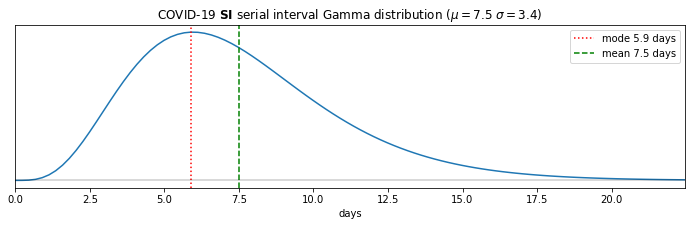

In [4]:
shape = SI_mu**2 / SI_sd**2 
scale = SI_sd**2 / SI_mu
SI_dist = sps.gamma(a=shape, scale=scale)
SI_x = np.linspace(SI_dist.ppf(0), SI_dist.ppf(.999), 100)
SI_y = SI_dist.pdf(SI_x)

omega = SI_x[SI_y.argmax()]
mean = SI_dist.stats(moments="m")

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(SI_x, SI_y)
ax.axvline(omega, c="r", ls=":", label=f"mode {omega:.1f} days")
ax.axvline(mean, c="g", ls="--", label=f"mean {mean:.1f} days")

ax.legend()
ax.axhline(0, c="k", alpha=.2)
ax.set_xlim(0, SI_x.max())
ax.set_yticks([])
ax.set_xlabel("days")
ax.set_title(fr"COVID-19 $\mathbf{{SI}}$ serial interval Gamma distribution ($\mu={SI_mu}$ $\sigma={SI_sd}$)")
plt.show();

Parameters $R_{t}$ will be distributed as **Half Normal** with mean equal to previous day posteriors 
$R_{t-1}$ and unknown precision $\tau$

$$
R_{{t}} \sim \mathcal{{N}}^+(R_{{t-1}}, \tau)
$$

where, first day $R_{{0}}$ (outcome) 
is set to zero

$$
R_{{0}} = 0
$$

and $\tau$ priors is distributed **Gamma** with shape and rate based on results of preliminary tests with uniformative $\tau$ distribution (ref: [Max Pierini 2020](https://maxpierini.it/ncov/Rt-MCMC.pdf))

$$
\tau \sim \Gamma(1000, 100)
$$

so that the standard deviation $\sigma$ will be

$$
\sigma = \frac{1}{\sqrt{\tau}}
$$

If previous new cases are zero $k_{t-1}=0$, parameter $R_{t}$ is undefined, given the chosen function for $\lambda_{t}$ parameter of Poisson likelihood, even if it should be $R_{t}=0$ (no new cases means null effective reproduction number). Thus, in these cases, priors of $R_{t}$ will be forced to

$$
R_{t} \sim \mathcal{N}^+(0, \tau)
\;,\; k_{t-1}=0
$$

and previous new cases will be forced to $k_{t-1}=1$, so that $\lambda_{t}$ will be

$$
\lambda_{t} = e^{\gamma( \mathcal{N}^+(0, \tau) - 1 )}
\;,\; k_{t-1}=0
$$

Percent positive (**PP**), aka _Percent Positive Rate_ or _Positivity Rate_, can be considered as an index of disease transmission (ref: [Johns Hopkins](https://www.jhsph.edu/covid-19/articles/covid-19-testing-understanding-the-percent-positive.html)).

The index is calculated as

$$
\mathbf{PP} = \frac{ \Delta_\textrm{positive} }{ \Delta_\textrm{tested} } \cdot 100
$$

where $\Delta_\textrm{positive}$ is daily new amount of positive tests and $\Delta_\textrm{tested}$ is daily new amount of total tests.

When it's too high means that more tests are needed and/or pharmaceutical (PI) or non-pharmaceutical (NPI) interventions should be seriously considered to reduce transmission.

The "alarm threshold" has been established at 5%. World Health Organization recommend to relax COVID-19 NPI (lockdown and high level social distancing rules) if **PP** keeps below the threshold for at least two weeks.

We can add an "alert" threshold, between 3% and 5%: if **PP** raises over 3%, governments should consider a likely forthcoming alarm scenario. Below 3% can be considered in a safe area.

Percent positive index for Italy is here calculated using Dipartimento di Protezione Civile published data (ref: [GitHub](https://github.com/pcm-dpc/COVID-19)) and smoothed with rolling mean (gaussian window of 7 days, $\sigma=2$).

To predict $y_{\mathrm{pred}}$ new cases in Italy for the next $d$ days, the same likelihood will be used, distributing new cases as **Poisson** with $\lambda_{\mathrm{pred}}$ parameter

$$
y_{\mathrm{pred},t} \sim \mathcal{P}(\lambda_{\mathrm{pred},t})
$$

where $\lambda_{\mathrm{pred},t}$ is parametrized on $\gamma$, the posteriors of estimated $y_{\mathrm{pred},t-1}$ and the $R_t^*$ mean of estimated Italy in the last observed $d$ days

$$
R_t^* = \frac{ \sum_{T-d}^{T}{R_i} }{ d }
$$

$$
\lambda_{\mathrm{pred}} = y_{\mathrm{pred},t-1} e^{\gamma (R_{t}^* - 1)}
$$

where $y_{\mathrm{pred},t-1}$ are distributed **Half Normal** with uknown precision

$$
y_{\mathrm{pred},t-1} \sim \mathcal{N}^+ \left( \mu=y_{\mathrm{pred},t-1} , \tau_{\mathrm{pred}} \right)
$$

and

$$
\tau_{\mathrm{pred}} \sim \Gamma( 1, 1)
$$

To predict best and worst scenario, $R_t^*$ will be supposed to be respectively higher and lower by 0.5

$$
R^*_{t,\mathrm{best}} = R_t^* - 0.5
$$

$$
R^*_{t,\mathrm{worst}} = R_t^* + 0.5
$$

Predicted $\mathbf{PP}_t$ will be calculated as

$$
\mathbf{PP}_t = \frac{ y_{\mathrm{pred},t} }{ \Delta_{\mathrm{tested}}^* } \cdot 100
$$

where $y_{\mathrm{pred},t}$ are estimated posteriors of predicted new cases and $\Delta_{\mathrm{tested}}^*$ is the last value of smoothed tested daily cases (gaussian window of 7 days, $\sigma=2$).

In [5]:
adapt = 500
warmup = 2000
sample = 2000

In [6]:
display(Markdown(f"""
A Markov chain Monte Carlo will be used with Metropolis-Hasting algorithm and Gibbs sampler 
(adapt {adapt}, warmup {warmup}, samples {sample}, chains 4, thin 1) in `Python 3.8.5` with `pyjags==1.3.7`
and `JAGS 4.3.0` for macOS.
"""))


A Markov chain Monte Carlo will be used with Metropolis-Hasting algorithm and Gibbs sampler 
(adapt 500, warmup 2000, samples 2000, chains 4, thin 1) in `Python 3.8.5` with `pyjags==1.3.7`
and `JAGS 4.3.0` for macOS.


The jupyter notebook backend is available at [GitHub](https://github.com/maxdevblock/COVID-Rt-MCMC).

In [7]:
it = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv",
     usecols=['data', 'nuovi_positivi', 'casi_testati'],
     parse_dates=['data'],
     index_col=['data'],
     squeeze=True).sort_index()

_ = """df = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
     usecols=['data', 'denominazione_regione', 'nuovi_positivi'],
     parse_dates=['data'],
     index_col=['denominazione_regione', 'data'],
     squeeze=True).sort_index()

countries = df.index.get_level_values("denominazione_regione").unique().sort_values()"""

days = it.index.get_level_values("data").unique()

In [8]:
yit = it['nuovi_positivi'].rolling(7,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=2).round().values
yit[yit<0] = 0

smoothed_tests = it['casi_testati'].diff().rolling(7,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=2).values

_ = """
Y = np.ndarray(shape=(countries.size, days.size))
for r, region in enumerate(countries):

    y = df.loc[region]
    lom = df.loc[region].rolling(7,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=2).round().values
    lom[lom<0] = 0
    
    Y[r] = lom"""

In [9]:
modelStringItaly = f"""
model {{
    ###################################
    # Rt estimation
    ###################################
    # Overarching Rt standard deviation
    tau_R ~ dgamma( 1000 , 100 )
    sigma_R <- 1 / sqrt( tau_R )

    # Serial interval distribution
    SI_mu <- {SI_mu}
    SI_sd <- {SI_sd}
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    # First Rt prior
    R[1] <- 0
    for ( t in 2:T ) {{
        # Rt prior for k>0
        Rpr[t] ~ dnorm( R[t-1] , tau_R )  T(0,)
        # Rt prior for k=0
        Rnu[t] ~ dnorm( 0 , tau_R )  T(0,)

        # Define Rt prior
        R[t] <- ifelse( k[t-1]==0 , Rnu[t] , Rpr[t] )
        # Avoid k=0 (undefined Rt)
        K[t] <- ifelse( k[t-1]==0, 1 , k[t-1] )

        # Poisson likelihood
        lambda[t] <- K[t] * exp( gamma * ( R[t] - 1 ) )
        y[t] ~ dpois( lambda[t] )
    }}
    
    ###################################
    # Predictions
    ###################################
    R_pred <- sum(R[(T-P):T]) / P
    R_pred_hi <- R_pred + 0.5
    R_pred_lo <- R_pred - 0.5
    y_pred[1] <- y[T]
    y_pred_hi[1] <- y[T]
    y_pred_lo[1] <- y[T]
    PP[1] <- PPobs
    PP_lo[1] <- PPobs
    PP_hi[1] <- PPobs
    
    # New cases precision prior
    y_tau ~ dgamma( 1 , 1 )
    
    for ( p in 2:P ) {{
        # most likely scenario
        y_prior[p] ~ dnorm( y_pred[p-1] , y_tau )  T(0,)
        lambda_pred[p] <- y_prior[p] * exp( gamma * ( R_pred - 1 ) )
        y_pred[p] ~ dpois( lambda_pred[p] )
        PP[p] <- y_pred[p] / tests * 100
        
        # worst scenario
        y_prior_hi[p] ~ dnorm( y_pred_hi[p-1] , y_tau )  T(0,)
        lambda_pred_hi[p] <- y_prior_hi[p] * exp( gamma * ( R_pred_hi - 1 ) )
        y_pred_hi[p] ~ dpois( lambda_pred_hi[p] )
        PP_hi[p] <- y_pred_hi[p] / tests * 100
        
        # best scenario
        y_prior_lo[p] ~ dnorm( y_pred_lo[p-1] , y_tau )  T(0,)
        lambda_pred_lo[p] <- y_prior_lo[p] * exp( gamma * ( R_pred_lo - 1 ) )
        y_pred_lo[p] ~ dpois( lambda_pred_lo[p] )
        PP_lo[p] <- y_pred_lo[p] / tests * 100
    }}
}}
"""

In [10]:
display(Markdown(f"```R\n{modelStringItaly}\n```"))

```R

model {
    ###################################
    # Rt estimation
    ###################################
    # Overarching Rt standard deviation
    tau_R ~ dgamma( 1000 , 100 )
    sigma_R <- 1 / sqrt( tau_R )

    # Serial interval distribution
    SI_mu <- 7.5
    SI_sd <- 3.4
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    # First Rt prior
    R[1] <- 0
    for ( t in 2:T ) {
        # Rt prior for k>0
        Rpr[t] ~ dnorm( R[t-1] , tau_R )  T(0,)
        # Rt prior for k=0
        Rnu[t] ~ dnorm( 0 , tau_R )  T(0,)

        # Define Rt prior
        R[t] <- ifelse( k[t-1]==0 , Rnu[t] , Rpr[t] )
        # Avoid k=0 (undefined Rt)
        K[t] <- ifelse( k[t-1]==0, 1 , k[t-1] )

        # Poisson likelihood
        lambda[t] <- K[t] * exp( gamma * ( R[t] - 1 ) )
        y[t] ~ dpois( lambda[t] )
    }
    
    ###################################
    # Predictions
    ###################################
    R_pred <- sum(R[(T-P):T]) / P
    R_pred_hi <- R_pred + 0.5
    R_pred_lo <- R_pred - 0.5
    y_pred[1] <- y[T]
    y_pred_hi[1] <- y[T]
    y_pred_lo[1] <- y[T]
    PP[1] <- PPobs
    PP_lo[1] <- PPobs
    PP_hi[1] <- PPobs
    
    # New cases precision prior
    y_tau ~ dgamma( 1 , 1 )
    
    for ( p in 2:P ) {
        # most likely scenario
        y_prior[p] ~ dnorm( y_pred[p-1] , y_tau )  T(0,)
        lambda_pred[p] <- y_prior[p] * exp( gamma * ( R_pred - 1 ) )
        y_pred[p] ~ dpois( lambda_pred[p] )
        PP[p] <- y_pred[p] / tests * 100
        
        # worst scenario
        y_prior_hi[p] ~ dnorm( y_pred_hi[p-1] , y_tau )  T(0,)
        lambda_pred_hi[p] <- y_prior_hi[p] * exp( gamma * ( R_pred_hi - 1 ) )
        y_pred_hi[p] ~ dpois( lambda_pred_hi[p] )
        PP_hi[p] <- y_pred_hi[p] / tests * 100
        
        # best scenario
        y_prior_lo[p] ~ dnorm( y_pred_lo[p-1] , y_tau )  T(0,)
        lambda_pred_lo[p] <- y_prior_lo[p] * exp( gamma * ( R_pred_lo - 1 ) )
        y_pred_lo[p] ~ dpois( lambda_pred_lo[p] )
        PP_lo[p] <- y_pred_lo[p] / tests * 100
    }
}

```

# Results

In [11]:
PP_obs = it['nuovi_positivi'][1:] / it['casi_testati'].diff()[1:] * 100
PP_smt = PP_obs.rolling(7,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=2).values

In [12]:
prediction = 7

model_data_italy = {
    "y": yit,
    "k": yit,
    "T": days.size,
    "P": prediction+1,
    "tests": smoothed_tests[-1],
    "PPobs": PP_smt[-1]
}

In [13]:
jags_posteriors_italy = None

print("Starting MCMC...")

jags_model_italy = pyjags.Model(
    code=modelStringItaly, 
    data=model_data_italy,
    chains=4, 
    adapt=adapt,
    progress_bar=True
)

jags_posteriors_italy = jags_model_italy.sample(
    warmup + sample, vars=["R", "sigma_R", "y_pred", "y_pred_hi", "y_pred_lo", "PP", "PP_hi", "PP_lo"]
)

clear_output()

with open("posterior_samples_italy.pkl", "wb") as f:
    pickle.dump(jags_posteriors_italy, f)

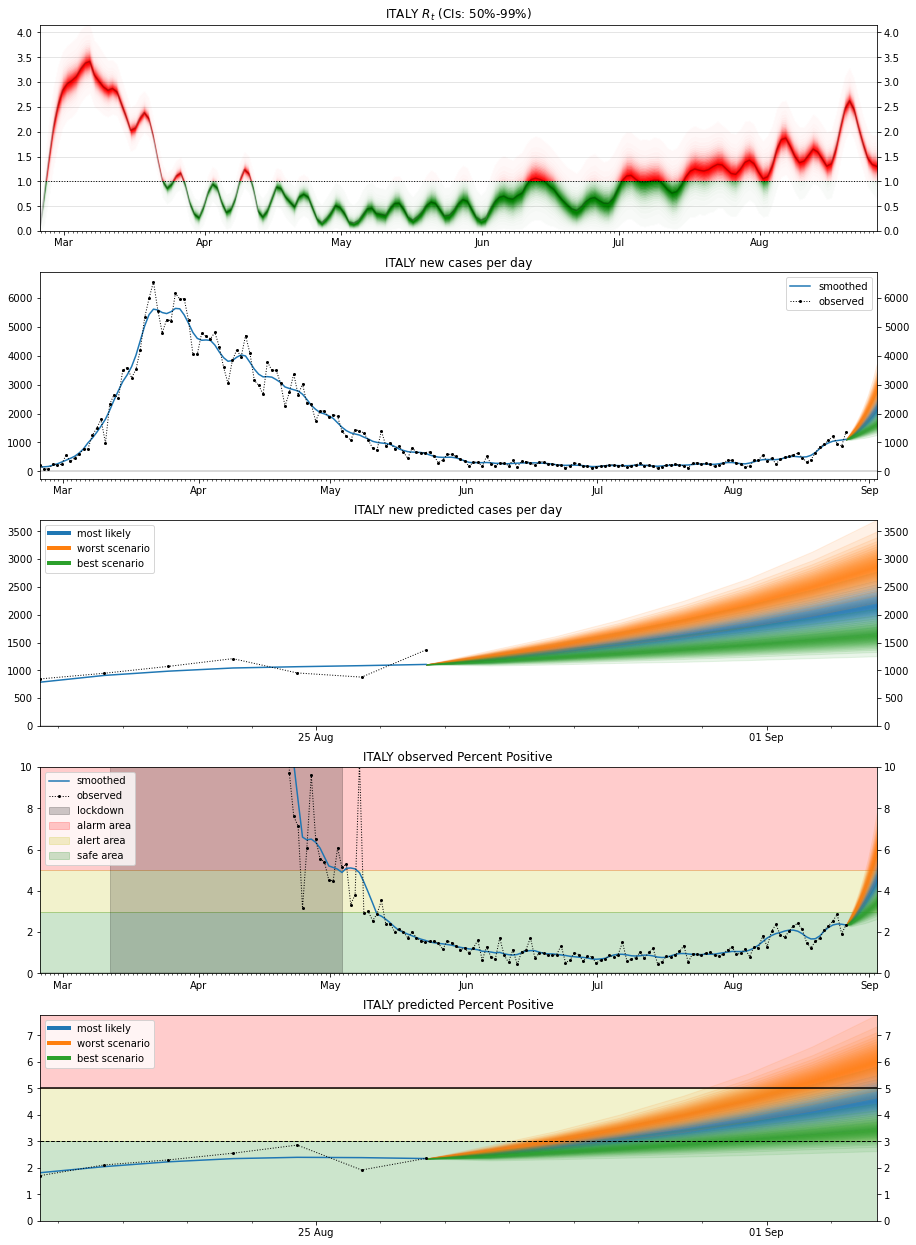

In [14]:
percs = np.linspace(50, 99, 20)

if not jags_posteriors_italy:
    with open("posterior_samples_italy.pkl", "rb") as f:
        jags_posteriors_italy = pickle.load(f)

ymax = np.array([])
uppers = np.ndarray(shape=(len(percs), days.size))
lowers = np.ndarray(shape=(len(percs), days.size))

pyjags_data_italy = az.from_pyjags(jags_posteriors_italy, warmup_iterations=warmup, save_warmup=False)
summary = az.summary(pyjags_data_italy, var_names="R", kind="stats")
for i, p in enumerate(percs[::-1]):
    upper = np.percentile(pyjags_data_italy.posterior.R, p, axis=1)
    upper = np.mean(upper, axis=0)
    lower = np.percentile(pyjags_data_italy.posterior.R, 100-p, axis=1)
    lower = np.mean(lower, axis=0)
    ymax = np.append(ymax, upper.max())
    uppers[i] = upper
    lowers[i] = lower
ymax = ymax.max()

        
fig, ax = plt.subplots(5, 1, figsize=(15, 22))

pred_days = pd.date_range(days[-1], days[-1]+pd.Timedelta(days=7), freq="1d")

y_predmax = np.array([])
PP_max = np.array([])
for c, pred in enumerate(['', '_hi', '_lo']):
    y_pred = f"y_pred{pred}"
    PP = f"PP{pred}"
    for i, p in enumerate(percs[::-1]):
        y_upper = np.percentile(pyjags_data_italy.posterior[y_pred], p, axis=1)
        y_upper = np.mean(y_upper, axis=0)
        PP_upper = np.percentile(pyjags_data_italy.posterior[PP], p, axis=1)
        PP_upper = np.mean(PP_upper, axis=0)
        
        y_lower = np.percentile(pyjags_data_italy.posterior[y_pred], 100-p, axis=1)
        y_lower = np.mean(y_lower, axis=0)
        PP_lower = np.percentile(pyjags_data_italy.posterior[PP], 100-p, axis=1)
        PP_lower = np.mean(PP_lower, axis=0)
        
        y_predmax = np.append(y_predmax, y_upper.max())
        PP_max = np.append(PP_max, PP_upper.max())
        
        ax[1].fill_between(pred_days, y_upper, y_lower, color=f"C{c}", alpha=.1)
        ax[2].fill_between(pred_days, y_upper, y_lower, color=f"C{c}", alpha=.1)
        
        ax[3].fill_between(pred_days, PP_upper, PP_lower, color=f"C{c}", alpha=.1)
        ax[4].fill_between(pred_days, PP_upper, PP_lower, color=f"C{c}", alpha=.1)
        
y_predmax = y_predmax.max()
PP_max = PP_max.max()

ax[1].plot(days, yit, label="smoothed")
ax[1].plot(days, it['nuovi_positivi'], 'ok:', lw=1, ms=2, label="observed")
ax[1].axhline(0, c="k", alpha=.2)
ax[1].set_xlim(days[0], days[-1]+pd.Timedelta(days=7))
ax[1].yaxis.set_ticks_position('both')
ax[1].tick_params(labelright=True)
ax[1].legend()
ax[1].set_title(f"ITALY new cases per day")

ax[2].set_ylim(0, y_predmax)
ax[2].plot(days, yit, label="smoothed")
ax[2].plot(days, it['nuovi_positivi'], 'ok:', lw=1, ms=2, label="observed")
ax[2].axhline(0, c="k", alpha=.2)
ax[2].set_xlim(days[-7], days[-1]+pd.Timedelta(days=7))
ax[2].yaxis.set_ticks_position('both')
ax[2].tick_params(labelright=True)
custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4),
                Line2D([0], [0], color="C2", lw=4)]
ax[2].legend(
    custom_lines, ['most likely', 'worst scenario', 'best scenario'],
    loc="upper left"
)
ax[2].set_title(f"ITALY new predicted cases per day")

PP_days = [days[0], pred_days[-1]]
ax[3].fill_betweenx(
    [0,100],
    days[days>=pd.to_datetime("2020-03-11")][0],
    days[days<=pd.to_datetime("2020-05-04")][-1],
    color="k", alpha=.2, label="lockdown"
)
ax[3].fill_between(PP_days, 5, 100, color="r", alpha=.2, label="alarm area", zorder=0)
ax[3].fill_between(PP_days, 3, 5, color="y", alpha=.2, label="alert area", zorder=0)
ax[3].fill_between(PP_days, 0, 3, color="g", alpha=.2, label="safe area", zorder=0)
ax[3].plot(days[1:], PP_smt, label="smoothed")
ax[3].plot(days[1:], PP_obs, 'ok:', lw=1, ms=2, label="observed")
ax[3].axhline(0, c="k", alpha=.2)
ax[3].set_xlim(days[0], pred_days[-1])
ax[3].set_ylim(0, 10)
ax[3].yaxis.set_ticks_position('both')
ax[3].tick_params(labelright=True)
ax[3].legend(loc="upper left")
ax[3].set_title(f"ITALY observed Percent Positive")

ax[4].set_ylim(0, PP_max)
ax[4].plot(days[1:], PP_smt, label="smoothed")
ax[4].plot(days[1:], PP_obs, 'ok:', lw=1, ms=2, label="observed")
ax[4].fill_between(PP_days, 5, 100, color="r", alpha=.2, label="alarm area", zorder=0)
ax[4].fill_between(PP_days, 3, 5, color="y", alpha=.2, label="alert area", zorder=0)
ax[4].fill_between(PP_days, 0, 3, color="g", alpha=.2, label="safe area", zorder=0)
ax[4].axhline(5, c="k")
ax[4].axhline(3, c="k", ls="--", lw=1)
ax[4].set_xlim(days[-7], days[-1]+pd.Timedelta(days=7))
ax[4].yaxis.set_ticks_position('both')
ax[4].tick_params(labelright=True)
custom_lines = [Line2D([0], [0], color="C0", lw=4),
                Line2D([0], [0], color="C1", lw=4),
                Line2D([0], [0], color="C2", lw=4)]
ax[4].legend(
    custom_lines, ['most likely', 'worst scenario', 'best scenario'],
    loc="upper left"
)
ax[4].set_title(f"ITALY predicted Percent Positive")


steps = .4/(len(percs)-1)
for i, (upper, lower) in enumerate(zip(uppers, lowers)):
    alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
    ax[0].fill_between(days, np.zeros(lower.size), lower, color="w", alpha=alpha)
    ax[0].fill_between(days, upper, np.ones(lower.size)*12, color="w", alpha=alpha)

ax[0].plot(days, summary["mean"], c="k", alpha=.25)

ax[0].hlines(np.arange(0, 12, .5), days[0], days[-1], color="k", lw=1, alpha=.1)
ax[0].axhline(1, c="k", ls=":", lw=1)

ax[0].fill_between(days, 1, 12, color="red", zorder=0) #, alpha=.2)
ax[0].fill_between(days, 0, 1, color="green", zorder=0) #, alpha=.2)

ax[0].set_xlim(days[0], days[-1])

ax[0].set_title(fr"ITALY $R_t$ (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")

ax[0].set_ylim(0, ymax)
ax[0].yaxis.set_ticks_position('both')
ax[0].tick_params(labelright=True)

for w in [2,4]:
    ax[w].xaxis.set_major_locator(mdates.WeekdayLocator())
    ax[w].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax[w].xaxis.set_minor_locator(mdates.DayLocator())
for w in [0,1,3]:
    ax[w].xaxis.set_major_locator(mdates.MonthLocator())
    ax[w].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax[w].xaxis.set_minor_locator(mdates.DayLocator())

plt.show()
plt.close(fig="all")

# MCMC diagnosis

## sigma

In [15]:
pyjags_data_sigma = az.from_pyjags(
    {"sigma_R": jags_posteriors_italy["sigma_R"]}, 
    warmup_iterations=warmup, save_warmup=False)

In [16]:
display(Latex(az.summary(pyjags_data_sigma, hdi_prob=.99, kind="stats").to_latex()))

<IPython.core.display.Latex object>

In [17]:
display(Latex(az.summary(pyjags_data_sigma, hdi_prob=.99, kind="diagnostics").to_latex()))

<IPython.core.display.Latex object>

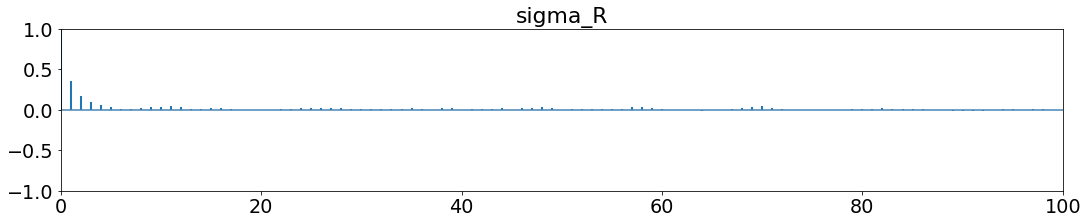

In [18]:
ax = az.plot_autocorr(
    pyjags_data_sigma,
    combined=True,
    max_lag=100,
    figsize=(15,3)
)
plt.show()
plt.close(fig="all")

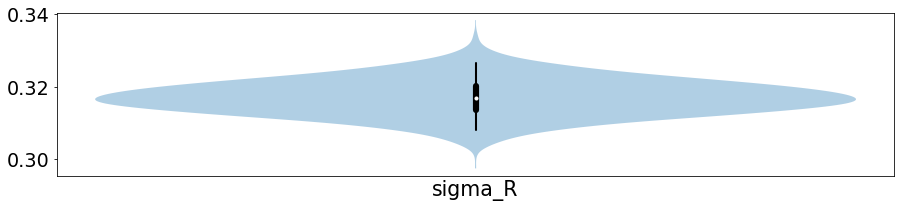

In [19]:
ax = az.plot_violin(
    pyjags_data_sigma,
    figsize=(15,3)
)
plt.show()
plt.close(fig="all")

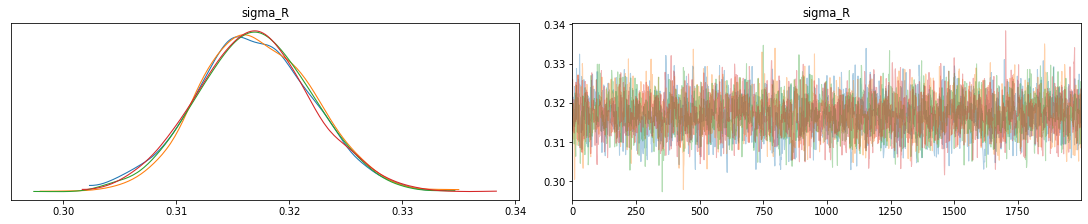

In [20]:
ax = az.plot_trace(
    pyjags_data_sigma,
    figsize=(15,3)
)
plt.show()
plt.close(fig="all")

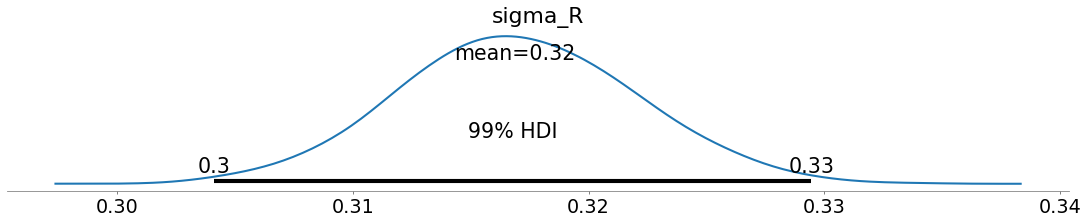

In [21]:
ax = az.plot_posterior(
    pyjags_data_sigma,
    hdi_prob=.99,
    figsize=(15,3)
)
plt.show()
plt.close(fig="all")

## Rt

In [22]:
auto_it = az.autocorr(jags_posteriors_italy["R"][:,warmup:,:], axis=1)

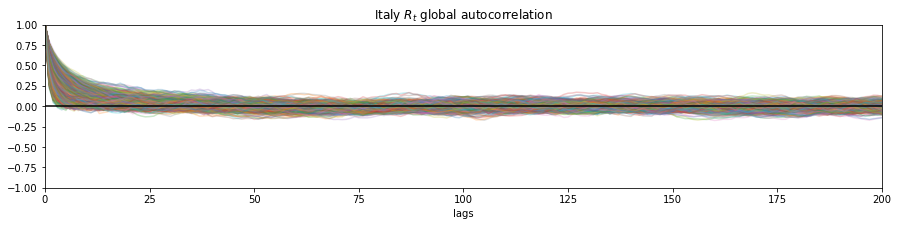

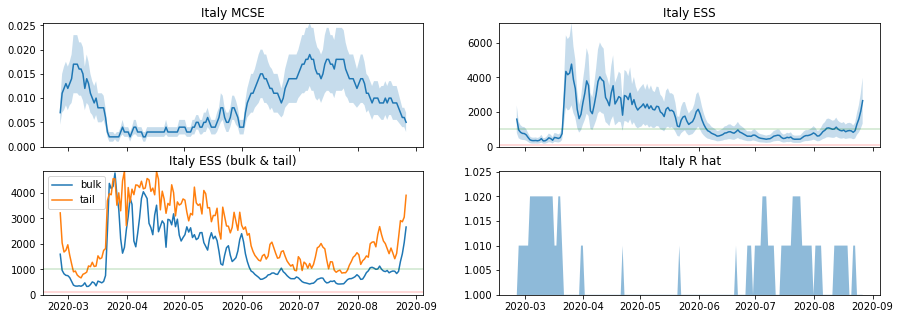

In [23]:
fig, ax = plt.subplots(figsize=(15, 3))
for day in auto_it:
    ax.plot(day[:,:], alpha=.25)
ax.set_xlim(0, 200)
ax.set_ylim(-1, 1)
ax.axhline(0, c="k")
ax.set_xlabel("lags")
ax.set_title("Italy $R_t$ global autocorrelation")
plt.show();

pyjags_data_R = az.from_pyjags(
{"R": jags_posteriors_italy["R"][1:,:,:]}, 
warmup_iterations=warmup, save_warmup=False)
smry = az.summary(pyjags_data_R, hdi_prob=.99)

fig, ax = plt.subplots(2, 2, figsize=(15, 5), sharex=True)
ax[0,0].plot(days[1:], smry["mcse_mean"])
ax[0,0].fill_between(
    days[1:],
    smry["mcse_mean"]-smry["mcse_sd"]/2,
    smry["mcse_mean"]+smry["mcse_sd"]/2,
    alpha=.25
)
ax[0,0].set_ylim(0, (smry["mcse_mean"]+smry["mcse_sd"]/2).max())
ax[0,0].set_title(f"Italy MCSE")

ax[0,1].plot(days[1:], smry["ess_mean"])
ax[0,1].fill_between(
    days[1:],
    smry["ess_mean"]-smry["ess_sd"]/2,
    smry["ess_mean"]+smry["ess_sd"]/2,
    alpha=.25
)
ax[0,1].axhline(100, c="r", alpha=.2)
ax[0,1].axhline(1000, c="g", alpha=.2)
ax[0,1].set_ylim(0, (smry["ess_mean"]+smry["ess_sd"]/2).max())
ax[0,1].set_title(f"Italy ESS")

ax[1,0].plot(days[1:], smry["ess_bulk"], label="bulk")
ax[1,0].plot(days[1:], smry["ess_tail"], label="tail")
ax[1,0].axhline(100, c="r", alpha=.2)
ax[1,0].axhline(1000, c="g", alpha=.2)
ax[1,0].set_ylim(0, max(smry['ess_bulk'].max(), smry['ess_tail'].max()))
ax[1,0].legend()
ax[1,0].set_title(f"Italy ESS (bulk & tail)")

ax[1,1].fill_between(days[1:], 0, smry["r_hat"], alpha=.5)
ax[1,1].set_ylim(smry["r_hat"].min(), smry["r_hat"].max()*1.005)
ax[1,1].set_title(f"Italy R hat")
plt.show()
plt.close(fig="all")

# Prediction tests

In [24]:
modelStringItalyPred = f"""
model {{
    ###################################
    # Rt estimation
    ###################################
    # Overarching Rt standard deviation
    tau_R ~ dgamma( 1000 , 100 )
    sigma_R <- 1 / sqrt( tau_R )

    # Serial interval distribution
    SI_mu <- {SI_mu}
    SI_sd <- {SI_sd}
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    # First Rt prior
    R[1] <- 0
    for ( t in 2:T ) {{
        # Rt prior for k>0
        Rpr[t] ~ dnorm( R[t-1] , tau_R )  T(0,)
        # Rt prior for k=0
        Rnu[t] ~ dnorm( 0 , tau_R )  T(0,)

        # Define Rt prior
        R[t] <- ifelse( k[t-1]==0 , Rnu[t] , Rpr[t] )
        # Avoid k=0 (undefined Rt)
        K[t] <- ifelse( k[t-1]==0, 1 , k[t-1] )

        # Poisson likelihood
        lambda[t] <- K[t] * exp( gamma * ( R[t] - 1 ) )
        y[t] ~ dpois( lambda[t] )
    }}
    
    ###################################
    # Predictions
    ###################################
    # New cases precision prior
    y_tau ~ dgamma( 1 , 1 )
    
    for ( t in U:(T-1)) {{
        R_pred[t] <- sum(R[(t-P):t]) / P
        R_pred_hi[t] <- R_pred[t] + 0.5
        R_pred_lo[t] <- R_pred[t] - 0.5
        y_pred[t,1] <- y[t]
        y_pred_hi[t,1] <- y[t]
        y_pred_lo[t,1] <- y[t]
        PP[t,1] <- PPobs[t]
        PP_lo[t,1] <- PPobs[t]
        PP_hi[t,1] <- PPobs[t]

        for ( p in 2:P ) {{
            # most likely scenario
            y_prior[t,p] ~ dnorm( y_pred[t,(p-1)] , y_tau )  T(0,)
            lambda_pred[t,p] <- y_prior[t,p] * exp( gamma * ( R_pred[t] - 1 ) )
            y_pred[t,p] ~ dpois( lambda_pred[t,p] )
            PP[t,p] <- y_pred[t,p] / tests[t] * 100

            # worst scenario
            y_prior_hi[t,p] ~ dnorm( y_pred_hi[t,(p-1)] , y_tau )  T(0,)
            lambda_pred_hi[t,p] <- y_prior_hi[t,p] * exp( gamma * ( R_pred_hi[t] - 1 ) )
            y_pred_hi[t,p] ~ dpois( lambda_pred_hi[t,p] )
            PP_hi[t,p] <- y_pred_hi[t,p] / tests[t] * 100

            # best scenario
            y_prior_lo[t,p] ~ dnorm( y_pred_lo[t,(p-1)] , y_tau )  T(0,)
            lambda_pred_lo[t,p] <- y_prior_lo[t,p] * exp( gamma * ( R_pred_lo[t] - 1 ) )
            y_pred_lo[t,p] ~ dpois( lambda_pred_lo[t,p] )
            PP_lo[t,p] <- y_pred_lo[t,p] / tests[t] * 100
        }}
    }}
}}
"""

In [25]:
display(Markdown(f"```R\n{modelStringItalyPred}\n```"))

```R

model {
    ###################################
    # Rt estimation
    ###################################
    # Overarching Rt standard deviation
    tau_R ~ dgamma( 1000 , 100 )
    sigma_R <- 1 / sqrt( tau_R )

    # Serial interval distribution
    SI_mu <- 7.5
    SI_sd <- 3.4
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    # First Rt prior
    R[1] <- 0
    for ( t in 2:T ) {
        # Rt prior for k>0
        Rpr[t] ~ dnorm( R[t-1] , tau_R )  T(0,)
        # Rt prior for k=0
        Rnu[t] ~ dnorm( 0 , tau_R )  T(0,)

        # Define Rt prior
        R[t] <- ifelse( k[t-1]==0 , Rnu[t] , Rpr[t] )
        # Avoid k=0 (undefined Rt)
        K[t] <- ifelse( k[t-1]==0, 1 , k[t-1] )

        # Poisson likelihood
        lambda[t] <- K[t] * exp( gamma * ( R[t] - 1 ) )
        y[t] ~ dpois( lambda[t] )
    }
    
    ###################################
    # Predictions
    ###################################
    # New cases precision prior
    y_tau ~ dgamma( 1 , 1 )
    
    for ( t in U:(T-1)) {
        R_pred[t] <- sum(R[(t-P):t]) / P
        R_pred_hi[t] <- R_pred[t] + 0.5
        R_pred_lo[t] <- R_pred[t] - 0.5
        y_pred[t,1] <- y[t]
        y_pred_hi[t,1] <- y[t]
        y_pred_lo[t,1] <- y[t]
        PP[t,1] <- PPobs[t]
        PP_lo[t,1] <- PPobs[t]
        PP_hi[t,1] <- PPobs[t]

        for ( p in 2:P ) {
            # most likely scenario
            y_prior[t,p] ~ dnorm( y_pred[t,(p-1)] , y_tau )  T(0,)
            lambda_pred[t,p] <- y_prior[t,p] * exp( gamma * ( R_pred[t] - 1 ) )
            y_pred[t,p] ~ dpois( lambda_pred[t,p] )
            PP[t,p] <- y_pred[t,p] / tests[t] * 100

            # worst scenario
            y_prior_hi[t,p] ~ dnorm( y_pred_hi[t,(p-1)] , y_tau )  T(0,)
            lambda_pred_hi[t,p] <- y_prior_hi[t,p] * exp( gamma * ( R_pred_hi[t] - 1 ) )
            y_pred_hi[t,p] ~ dpois( lambda_pred_hi[t,p] )
            PP_hi[t,p] <- y_pred_hi[t,p] / tests[t] * 100

            # best scenario
            y_prior_lo[t,p] ~ dnorm( y_pred_lo[t,(p-1)] , y_tau )  T(0,)
            lambda_pred_lo[t,p] <- y_prior_lo[t,p] * exp( gamma * ( R_pred_lo[t] - 1 ) )
            y_pred_lo[t,p] ~ dpois( lambda_pred_lo[t,p] )
            PP_lo[t,p] <- y_pred_lo[t,p] / tests[t] * 100
        }
    }
}

```

In [26]:
prediction = 7
U = ((it['casi_testati']>0).values).nonzero()[0][0]

model_data_italy_pred = {
    "y": yit,
    "k": yit,
    "T": days.size,
    "P": prediction+1,
    "tests": smoothed_tests,
    "PPobs": PP_smt,
    "U": U
}

In [27]:
print("Starting MCMC...")

jags_model_italy_pred = pyjags.Model(
    code=modelStringItalyPred, 
    data=model_data_italy_pred,
    chains=4, 
    adapt=adapt,
    progress_bar=True
)

jags_posteriors_italy_pred = jags_model_italy_pred.sample(
    warmup + sample, vars=["R", "sigma_R", "y_pred", "y_pred_hi", "y_pred_lo", "PP", "PP_hi", "PP_lo"]
)

clear_output()

with open("posterior_samples_italy_pred.pkl", "wb") as f:
    pickle.dump(jags_posteriors_italy_pred, f)

## New cases

Legenda:

- dotted black line: observed new cases
- solid blu line: smoothed new cases
- blu area: most likely predicted new cases HPDI 90%
- green area: best scenario predicted new cases HPDI 99%
- orange area: worst scenario predicted new cases HPDI 99%

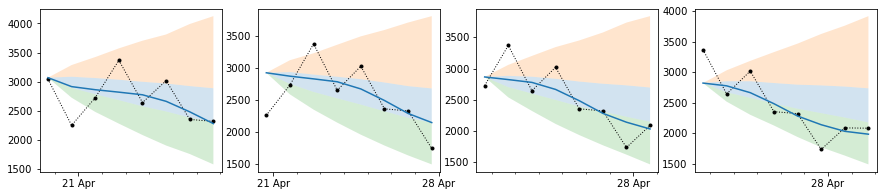

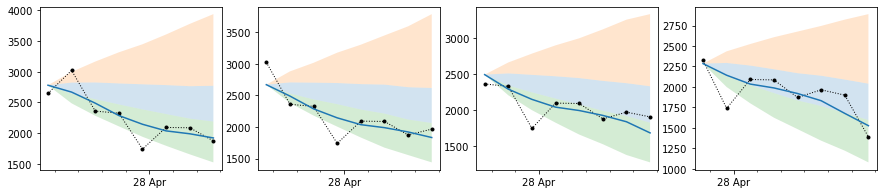

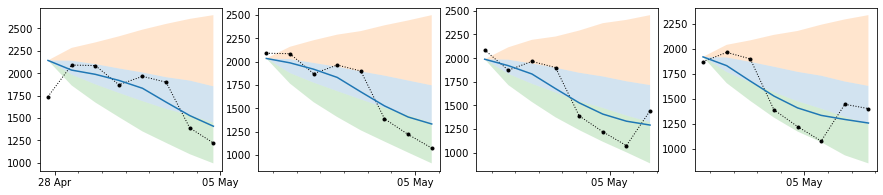

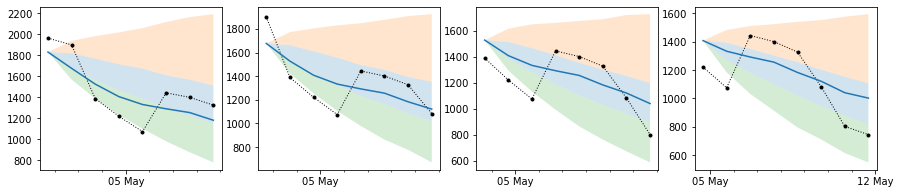

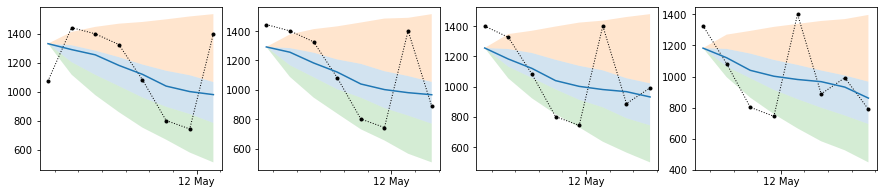

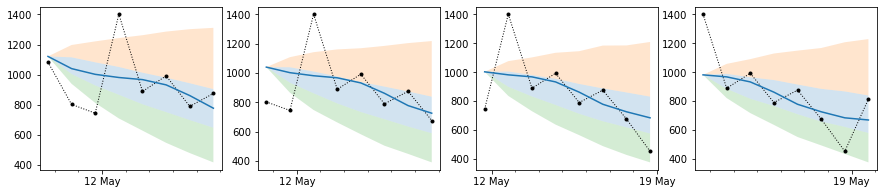

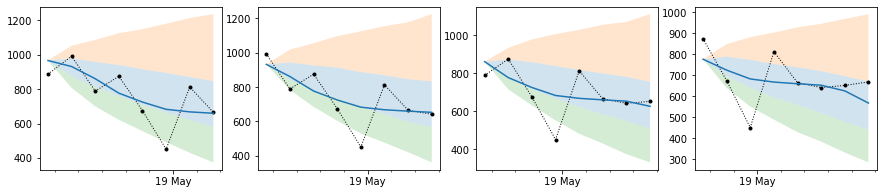

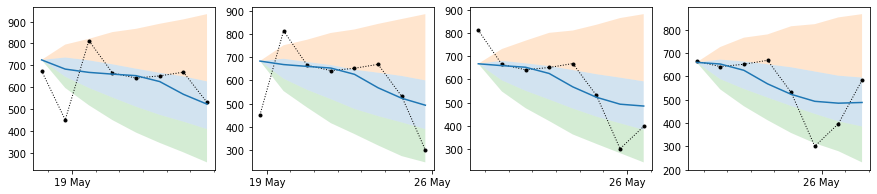

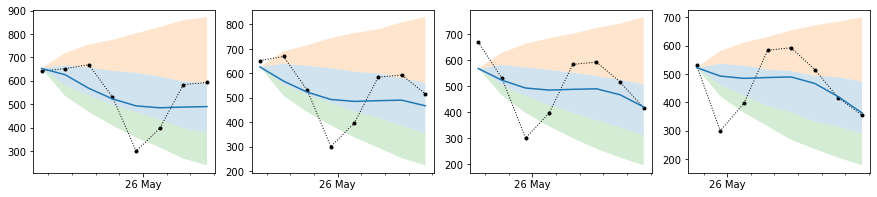

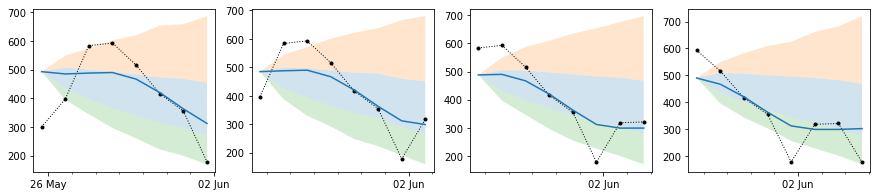

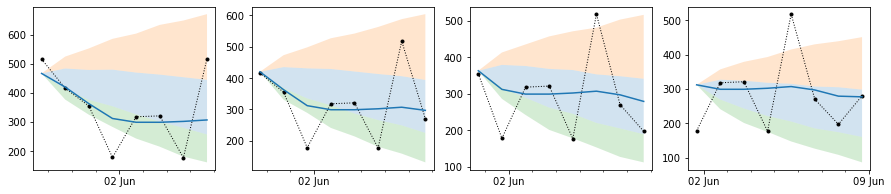

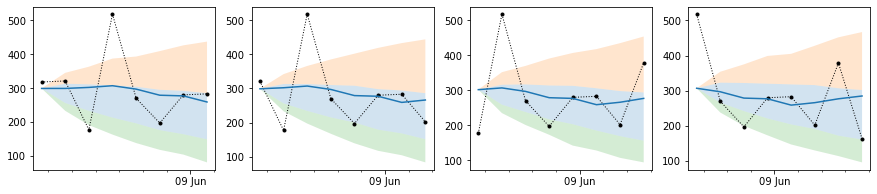

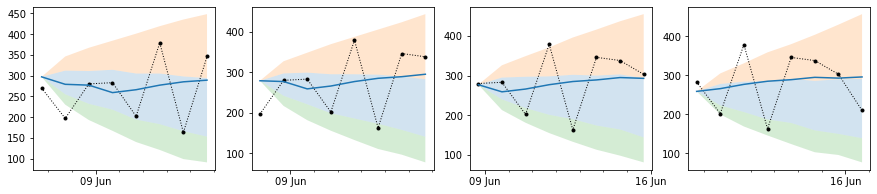

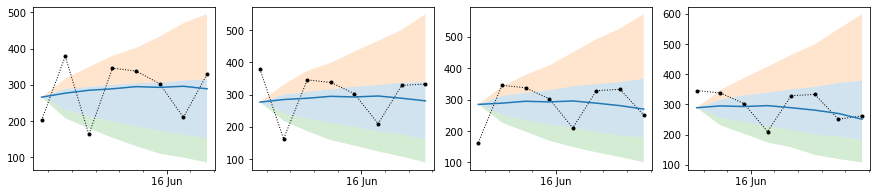

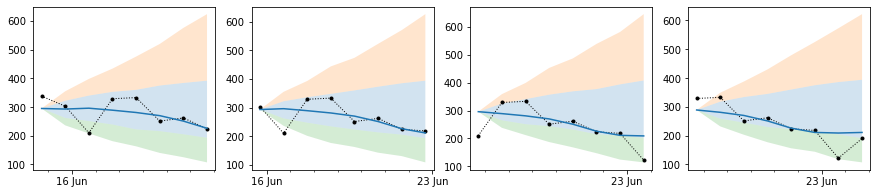

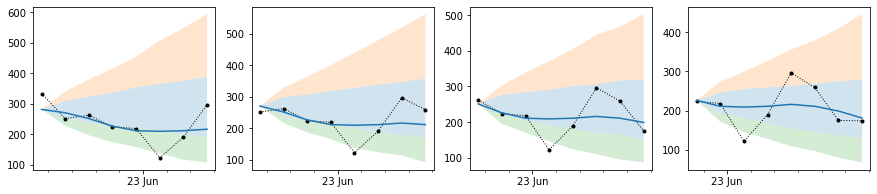

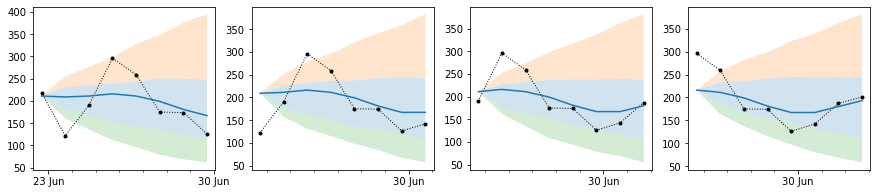

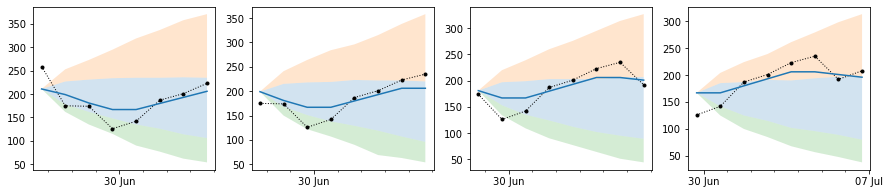

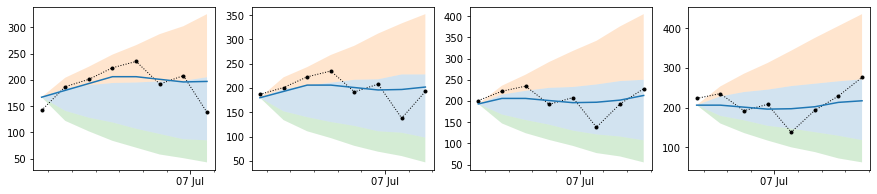

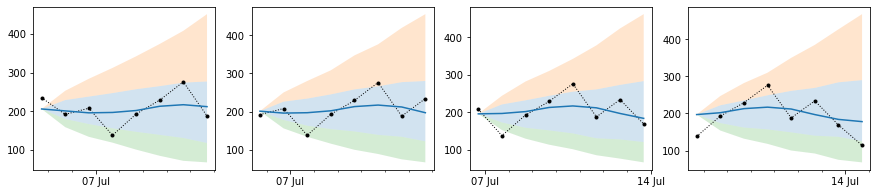

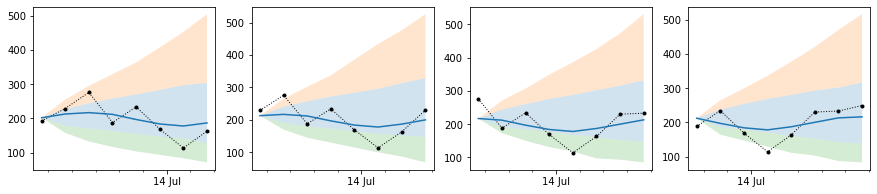

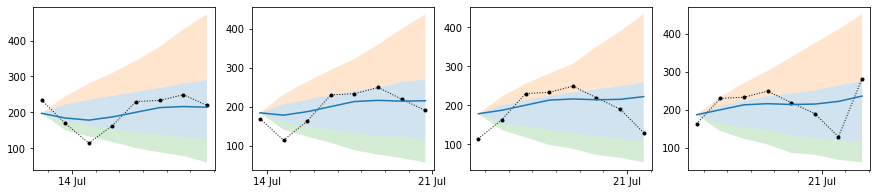

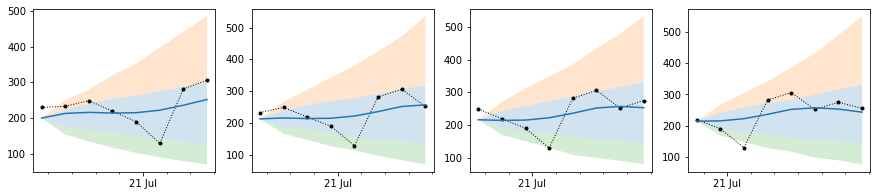

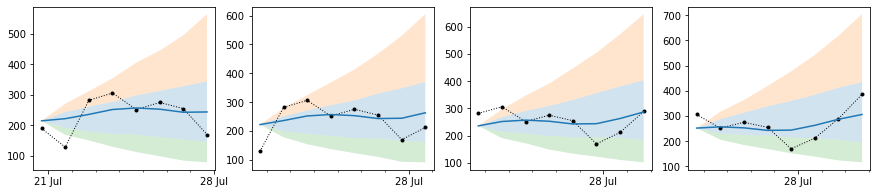

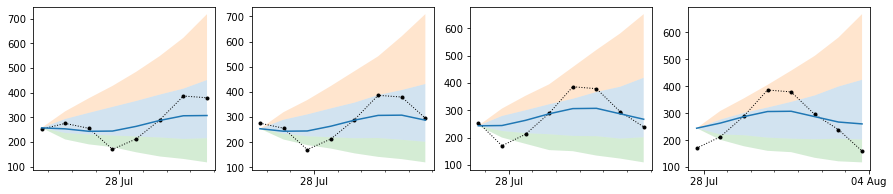

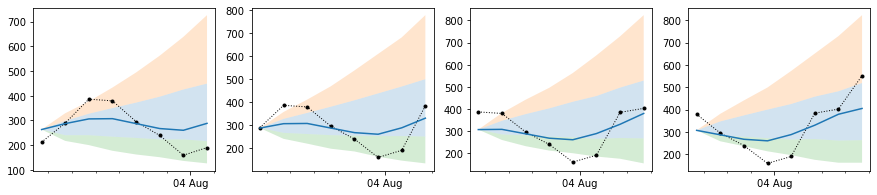

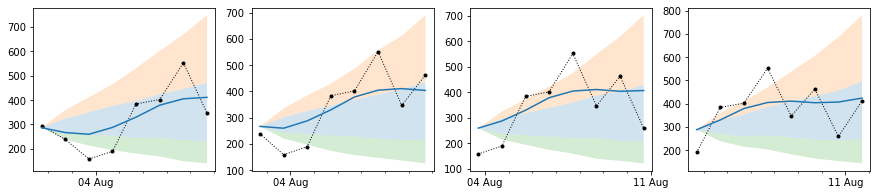

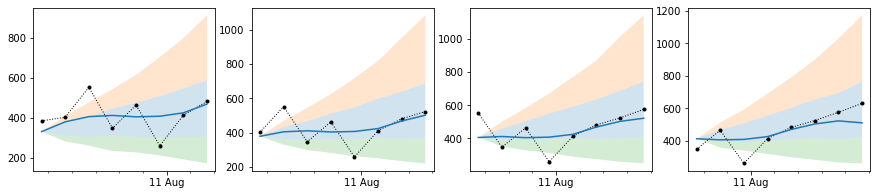

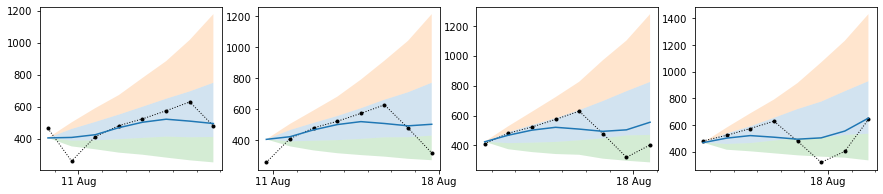

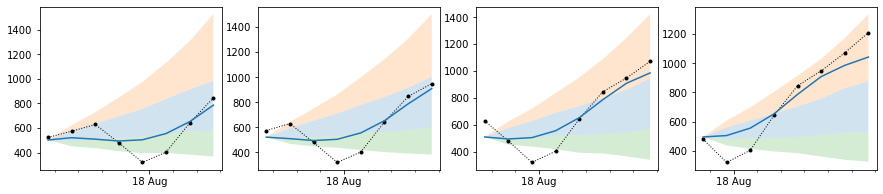

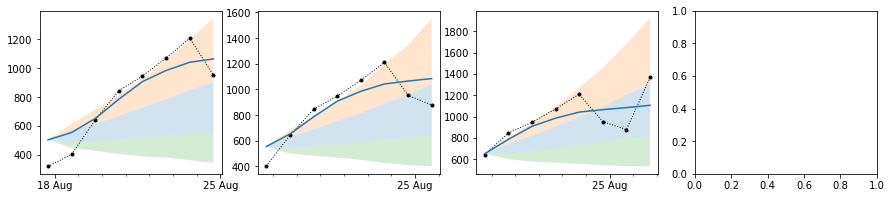

In [28]:
rows = 4

for i, u in enumerate(np.arange(U, (days.size-prediction), 1)):
    if not i % rows:
        fig, ax = plt.subplots(1, rows, figsize=(15, 3))
        
    pyjags_data_italy_pred = az.from_pyjags(
        {'y_pred': jags_posteriors_italy_pred['y_pred'].data[u]}, warmup_iterations=warmup, save_warmup=False
    )
    pyjags_data_italy_pred_hi = az.from_pyjags(
        {'y_pred': jags_posteriors_italy_pred['y_pred_hi'].data[u]}, warmup_iterations=warmup, save_warmup=False
    )
    pyjags_data_italy_pred_lo = az.from_pyjags(
        {'y_pred': jags_posteriors_italy_pred['y_pred_lo'].data[u]}, warmup_iterations=warmup, save_warmup=False
    )
    smry = az.summary(pyjags_data_italy_pred, hdi_prob=.9, kind="stats")
    smry_hi = az.summary(pyjags_data_italy_pred_hi, hdi_prob=.99, kind="stats")
    smry_lo = az.summary(pyjags_data_italy_pred_lo, hdi_prob=.99, kind="stats")
    
    ax[i%rows].plot(
        it.iloc[u:(u+prediction+1)]['nuovi_positivi'],
        'ok:', lw=1, ms=3
    )
    ax[i%rows].plot(
        it.index[u:(u+prediction+1)],
        yit[u:(u+prediction+1)]
    )
    ax[i%rows].fill_between(
        it.index[u:(u+prediction+1)],
        smry['hdi_5%'], smry['hdi_95%'],
        alpha=.2
    )
    ax[i%rows].fill_between(
        it.index[u:(u+prediction+1)],
        smry['hdi_95%'], smry_hi['hdi_99.5%'],
        alpha=.2
    )
    ax[i%rows].fill_between(
        it.index[u:(u+prediction+1)],
        smry_lo['hdi_0.5%'], smry['hdi_5%'],
        alpha=.2
    )
    ax[i%rows].xaxis.set_major_locator(mdates.WeekdayLocator())
    ax[i%rows].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax[i%rows].xaxis.set_minor_locator(mdates.DayLocator())
    
    if i % rows == rows - 1:
        plt.show()
        plt.close(fig="all")

## Percent Positive

Legenda:

- dotted black line: observed Percent Positive
- solid blu line: smoothed Percent Positive
- blu area: most likely predicted Percent Positive HPDI 90%
- green area: best scenario predicted Percent Positive HPDI 99%
- orange area: worst scenario predicted Percent Positive HPDI 99%

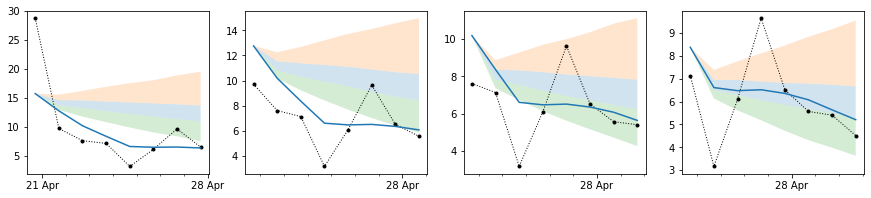

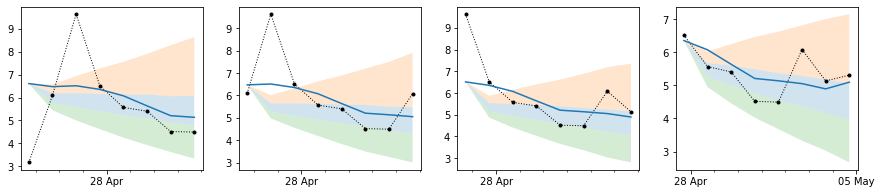

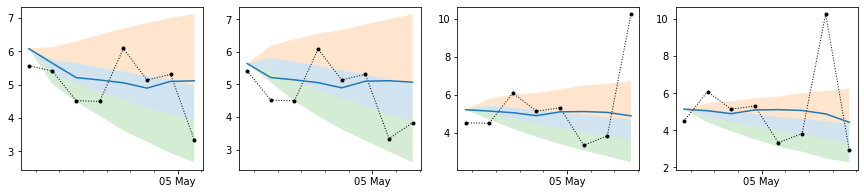

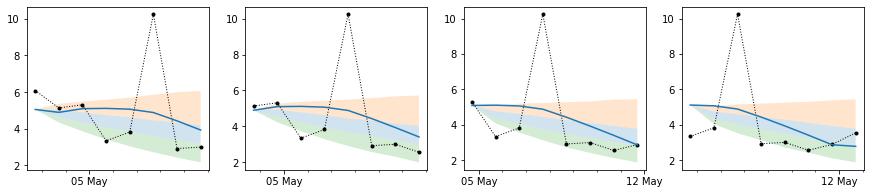

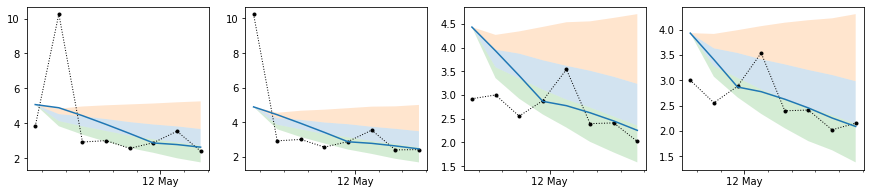

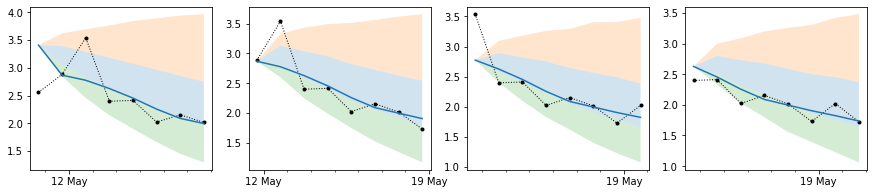

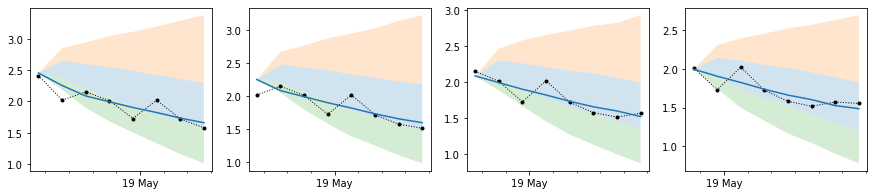

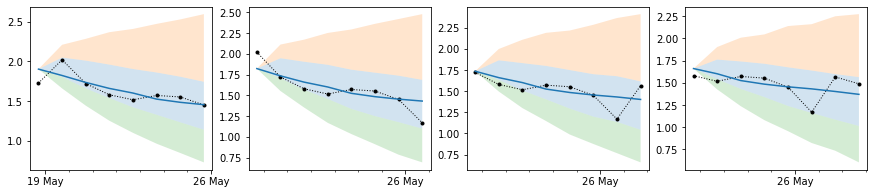

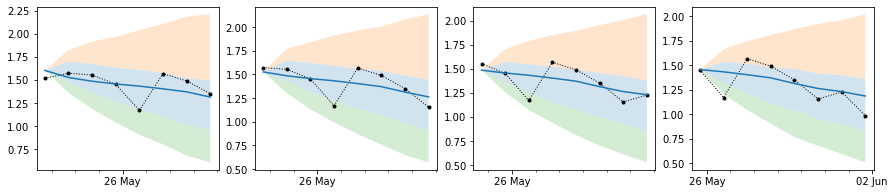

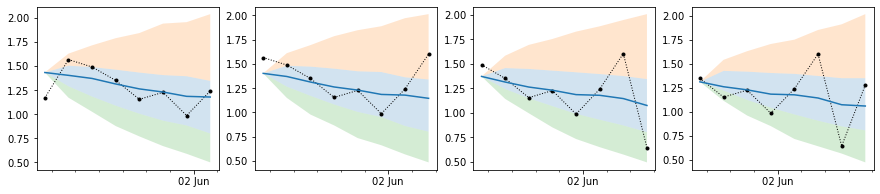

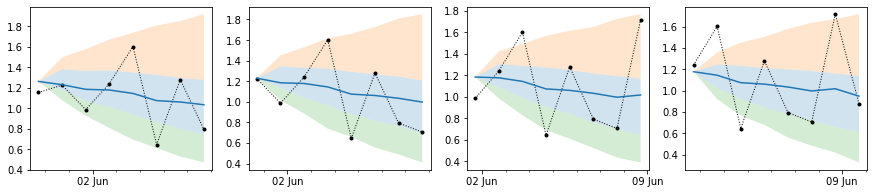

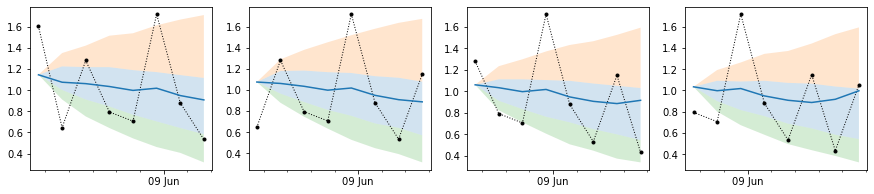

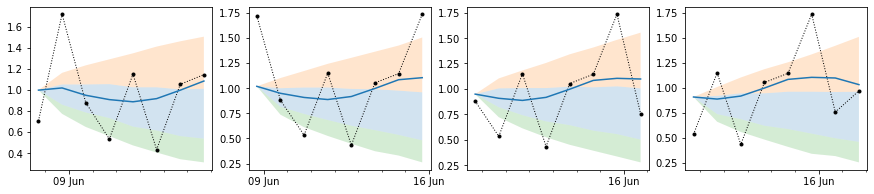

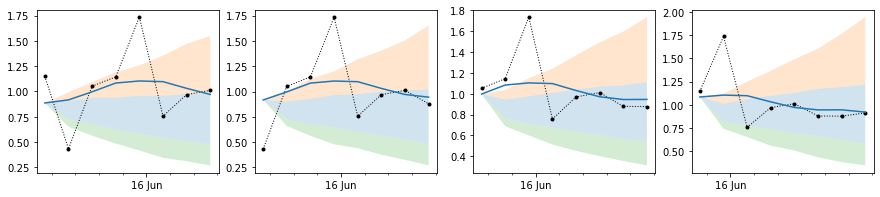

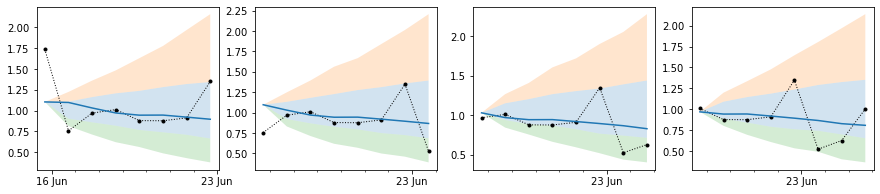

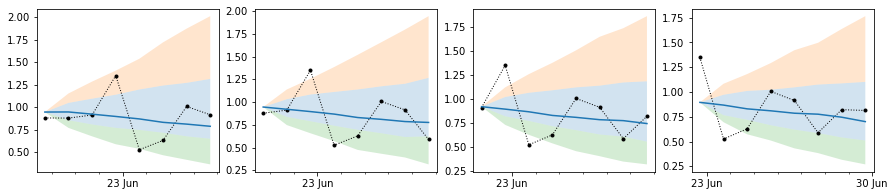

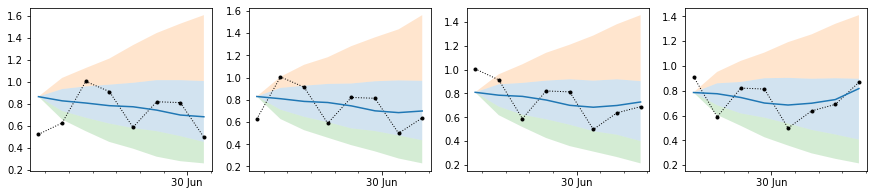

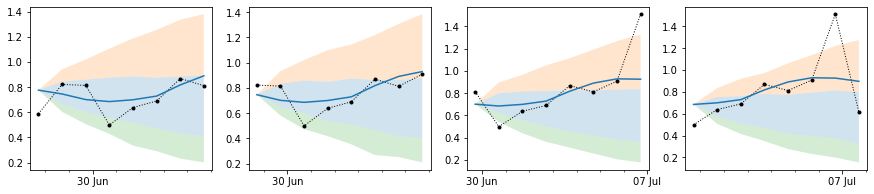

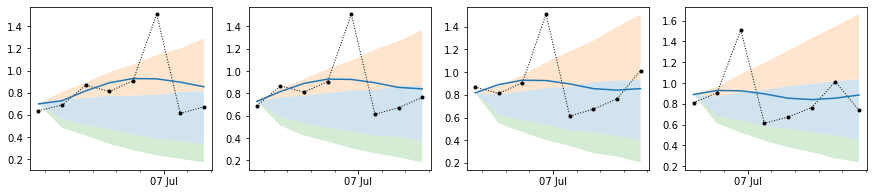

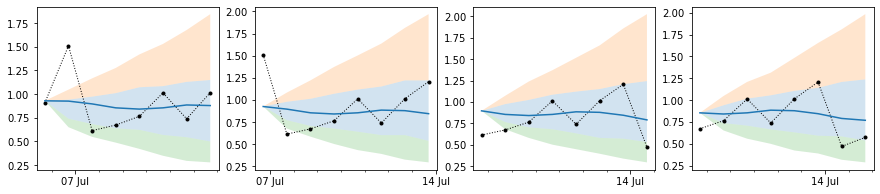

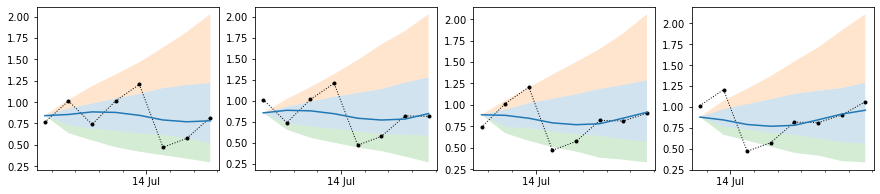

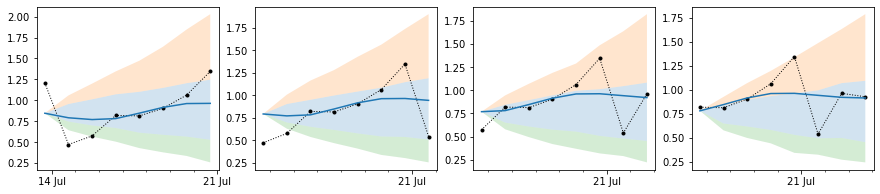

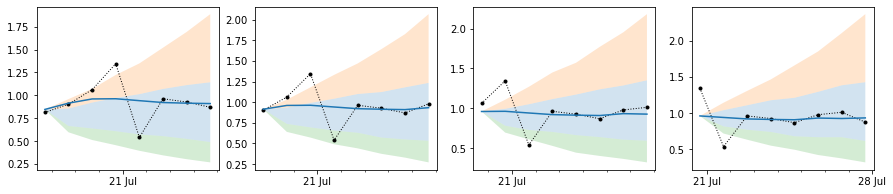

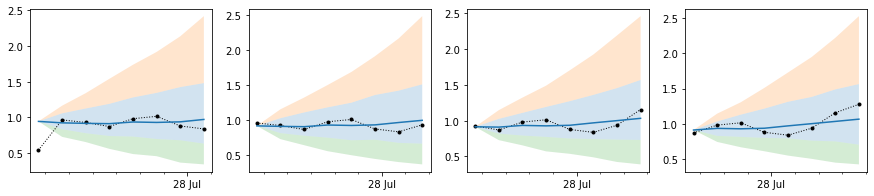

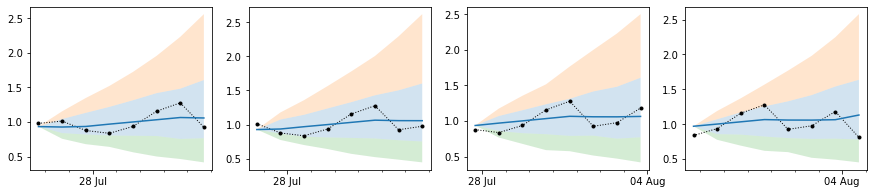

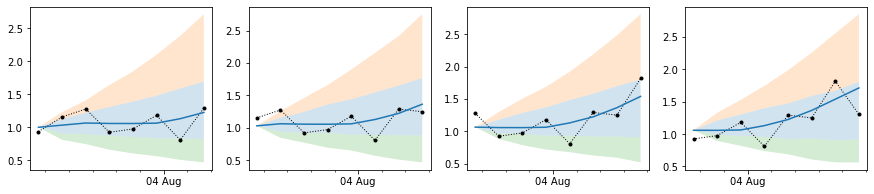

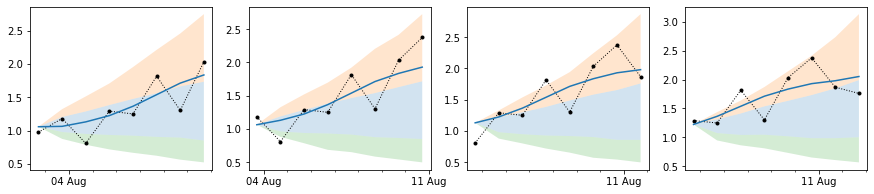

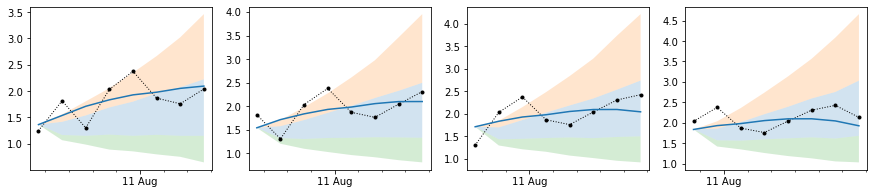

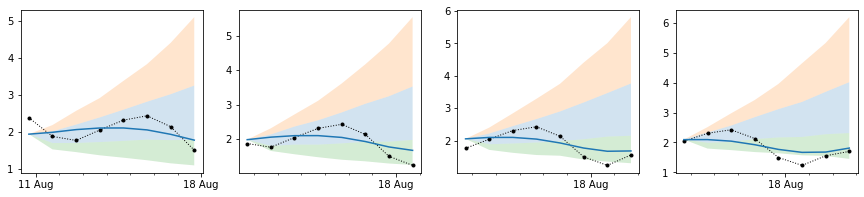

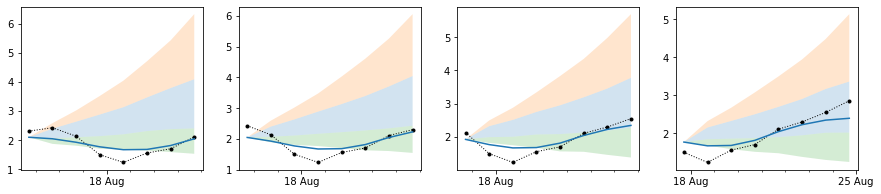

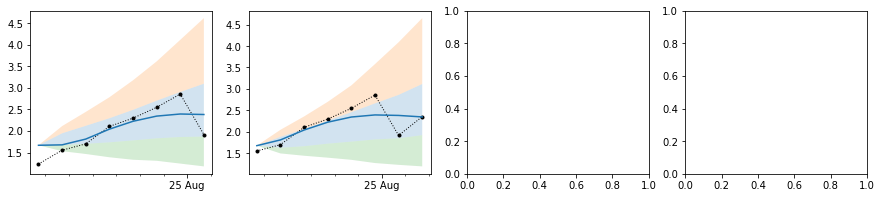

In [29]:
rows = 4

for i, u in enumerate(np.arange(U, (days.size-prediction-1), 1)):
    if not i % rows:
        fig, ax = plt.subplots(1, rows, figsize=(15, 3))
        
    pyjags_data_italy_pred = az.from_pyjags(
        {'PP': jags_posteriors_italy_pred['PP'].data[u]}, warmup_iterations=warmup, save_warmup=False
    )
    pyjags_data_italy_pred_hi = az.from_pyjags(
        {'PP': jags_posteriors_italy_pred['PP_hi'].data[u]}, warmup_iterations=warmup, save_warmup=False
    )
    pyjags_data_italy_pred_lo = az.from_pyjags(
        {'PP': jags_posteriors_italy_pred['PP_lo'].data[u]}, warmup_iterations=warmup, save_warmup=False
    )
    smry = az.summary(pyjags_data_italy_pred, hdi_prob=.9, kind="stats")
    smry_hi = az.summary(pyjags_data_italy_pred_hi, hdi_prob=.99, kind="stats")
    smry_lo = az.summary(pyjags_data_italy_pred_lo, hdi_prob=.99, kind="stats")
    
    ax[i%rows].plot(
        PP_obs.iloc[u:(u+prediction+1)],
        'ok:', lw=1, ms=3
    )
    ax[i%rows].plot(
        PP_obs.index[u:(u+prediction+1)],
        PP_smt[u:(u+prediction+1)]
    )
    ax[i%rows].fill_between(
        PP_obs.index[u:(u+prediction+1)],
        smry['hdi_5%'], smry['hdi_95%'],
        alpha=.2
    )
    ax[i%rows].fill_between(
        PP_obs.index[u:(u+prediction+1)],
        smry['hdi_95%'], smry_hi['hdi_99.5%'],
        alpha=.2
    )
    ax[i%rows].fill_between(
        PP_obs.index[u:(u+prediction+1)],
        smry_lo['hdi_0.5%'], smry['hdi_5%'],
        alpha=.2
    )
    ax[i%rows].xaxis.set_major_locator(mdates.WeekdayLocator())
    ax[i%rows].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax[i%rows].xaxis.set_minor_locator(mdates.DayLocator())
    
    if i % rows == rows - 1:
        plt.show()
        plt.close(fig="all")